In [1]:
import os
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

#Run from server

gpu4 = "GPU-71b4cdfc-e381-0b98-9b24-4fc06284b496" 
gpu5 = "GPU-99d0769a-9f86-4800-a40e-2320dddcf5d1" 
gpu6 = "GPU-7423cfb5-cff4-ec4d-7e96-ea6e1591d56f"
gpu7 = "GPU-c0a8738f-6dd0-1b78-c38f-4969fd3886a8"

os.environ["CUDA_VISIBLE_DEVICES"]= gpu6 + "," + gpu5

print(get_available_devices())

['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0', '/device:XLA_GPU:1', '/device:GPU:0', '/device:GPU:1']


In [22]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

In [57]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Lambda, GlobalAveragePooling2D, concatenate
from tensorflow.keras.layers import UpSampling2D, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

In [39]:
ImgDir = os.path.join("..","data","MICCAI_BraTS2020_TrainingData")
features_path = list()
labels_path = list()
count = 0
lim = 10

for folder in os.listdir(ImgDir):
    count +=1
    if 'Training' in folder and count<lim:
        new_dir = os.path.join(ImgDir,folder)
        data = os.listdir(new_dir)
        for files in data:
            if 'flair' in files:
                features_path.append(os.path.join(new_dir, files))
            if 'seg' in files:
                labels_path.append(os.path.join(new_dir, files))

print(len(features_path), features_path)
print(len(labels_path), labels_path)


9 ['../data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_034/BraTS20_Training_034_flair.nii.gz', '../data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_217/BraTS20_Training_217_flair.nii.gz', '../data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_239/BraTS20_Training_239_flair.nii.gz', '../data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_214/BraTS20_Training_214_flair.nii.gz', '../data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_304/BraTS20_Training_304_flair.nii.gz', '../data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_040/BraTS20_Training_040_flair.nii.gz', '../data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_057/BraTS20_Training_057_flair.nii.gz', '../data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_017/BraTS20_Training_017_flair.nii.gz', '../data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_320/BraTS20_Training_320_flair.nii.gz']
9 ['../data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_034/BraTS20_Training_034_seg.nii.gz', '../data/MICCAI_BraTS2020_TrainingDa

(1, 240, 240, 155)
(2, 240, 240, 155)
(3, 240, 240, 155)
(4, 240, 240, 155)
(5, 240, 240, 155)
(6, 240, 240, 155)
(7, 240, 240, 155)
(8, 240, 240, 155)
(9, 240, 240, 155)


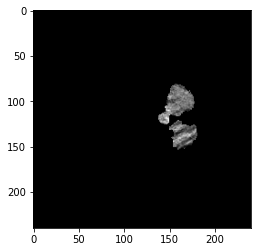

In [42]:
img_conc = []

for file in (features_path):
    img = nib.load(file)
    imgarr = img.get_fdata()
    img_conc.append(imgarr)
    print(np.shape(img_conc))
    
img_conc = np.concatenate(img_conc,axis=2)

img = nib.load(features_path[0])
imgarr = img.get_fdata()[:,:,10]
plt.imshow(imgarr, cmap ='gray')

In [51]:
img_conc_nii=nib.Nifti1Image(img_conc, np.eye(4))

In [52]:
nib.save(img_conc_nii, os.path.join('..','data','test.nii.gz'))  

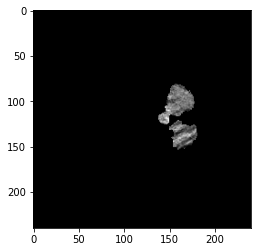

In [53]:
images = nib.load(os.path.join('..','data','test.nii.gz'))
imgarr = img.get_fdata()[:,:,10]
plt.imshow(imgarr, cmap ='gray')

In [66]:
print(np.shape(imgarr))

(240, 240)


In [60]:
IMG_HEIGHT = 240
IMG_WIDTH = 240
smooth = 0.005

In [61]:
def get_model():
    in1 = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1 ))

    conv1 = Conv2D(4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(in1)
    conv1 = Dropout(0.5)(conv1)
    conv1 = Conv2D(4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Dropout(0.5)(conv2)
    conv2 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = Dropout(0.5)(conv3)
    conv3 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = Dropout(0.5)(conv4)
    conv4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

    up1 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up1)
    conv5 = Dropout(0.5)(conv5)
    conv5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)
    
    up2 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv6 = Dropout(0.5)(conv6)
    conv6 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    up2 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv7 = Dropout(0.5)(conv7)
    conv7 = Conv2D(4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    segmentation = Conv2D(1, (1, 1), activation='sigmoid', name='seg')(conv7)

    model = Model(inputs=[in1], outputs=[segmentation])   

    model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy']
             )

    return model

In [62]:
model2=get_model()
model2.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 240, 4)  40          input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 240, 240, 4)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 4)  148         dropout[0][0]                    
_______________________________________________________________________________________

In [ ]:
model.fit()